# Train and Save Models

Run this script to train all the models on the training data (DynaSent round 2) and save the models as .pt files.

## Set-up

See [the first notebook in this unit](sst_01_overview.ipynb#Set-up) for set-up instructions.

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from datasets import load_dataset
import transformers

import sst
import utils

In [2]:
transformers.utils.logging.set_verbosity_error()
device = "cuda" if torch.cuda.is_available() else "cpu"
utils.fix_random_seeds()

## Dataset

Our primary train/dev/test set is DynaSent Round 2. See more details here: https://huggingface.co/datasets/dynabench/dynasent

In [3]:
dyna_r1 = load_dataset("dynabench/dynasent", "dynabench.dynasent.r1.all")
dyna_r1_train = dyna_r1['train'].to_pandas()
dyna_r1_dev = dyna_r1['validation'].to_pandas()
dyna_r2 = load_dataset("dynabench/dynasent", "dynabench.dynasent.r2.all")
dyna_r2_train = dyna_r2['train'].to_pandas()
dyna_r2_dev = dyna_r2['validation'].to_pandas()
print(f'dyna_r2_train.shape: {dyna_r2_train.shape}')
print(f'dyna_r2_dev.shape: {dyna_r2_dev.shape}')

TRAIN_DATAFRAMES = [dyna_r1_train, dyna_r2_train]
TRAIN_DATAFRAMES = [dyna_r2_train] # Only train on r2 for speed
DEV_DATAFRAMES = [dyna_r1_dev, dyna_r2_dev]

print(f'Train dataset length: {sum([len(df) for df in TRAIN_DATAFRAMES])}')
print(f'Test dataset length:  {sum([len(df) for df in DEV_DATAFRAMES])}')

Reusing dataset dynabench_dyna_sent (C:\Users\Gabe\.cache\huggingface\datasets\dynabench___dynabench_dyna_sent\dynabench.dynasent.r1.all\1.1.0\ab89971d9ae1aacc59ed44d6855bf0e89167417257e2c2666f38e532148f2967)
100%|██████████| 3/3 [00:00<00:00, 428.16it/s]
Reusing dataset dynabench_dyna_sent (C:\Users\Gabe\.cache\huggingface\datasets\dynabench___dynabench_dyna_sent\dynabench.dynasent.r2.all\1.1.0\ab89971d9ae1aacc59ed44d6855bf0e89167417257e2c2666f38e532148f2967)
100%|██████████| 3/3 [00:00<00:00, 499.46it/s]

dyna_r2_train.shape: (13065, 12)
dyna_r2_dev.shape: (720, 12)
Train dataset length: 13065
Test dataset length:  4320


In [4]:
dyna_r2_train.sample(1, random_state=1).to_dict(orient='records')

[{'id': 'r2-0002527',
  'hit_ids': array(['y23152'], dtype=object),
  'sentence': "The car is unsafe and Peoria Ford just says  us it's Ford.",
  'sentence_author': 'w1985',
  'has_prompt': True,
  'prompt_data': {'indices_into_review_text': array([378, 442]),
   'review_rating': 1,
   'prompt_sentence': "The car is unsafe and Peoria Ford just says it not us it's Ford.",
   'review_id': 'kUMkF_C6KVS4bRbOx_libQ'},
  'model_1_label': 'negative',
  'model_1_probs': {'negative': 0.7570458054542542,
   'positive': 0.14265362918376923,
   'neutral': 0.1003006249666214},
  'text_id': 'r2-0002527',
  'label_distribution': {'positive': array(['w121'], dtype=object),
   'negative': array(['w128', 'w23', 'w130', 'w80'], dtype=object),
   'neutral': array([], dtype=object),
   'mixed': array([], dtype=object)},
  'gold_label': 'negative',
  'metadata': {'split': 'train',
   'round': 2,
   'subset': 'all',
   'model_in_the_loop': 'RoBERTa'}}]

Here is the label distribution:

In [5]:
print("dyna_r1_train:")
print(dyna_r1_train.gold_label.value_counts())
print("dyna_r2_train:")
print(dyna_r2_train.gold_label.value_counts())
print("dyna_r1_dev:")
print(dyna_r1_dev.gold_label.value_counts())
print("dyna_r2_dev:")
print(dyna_r2_dev.gold_label.value_counts())


dyna_r1_train:
neutral     45076
positive    21391
negative    14021
Name: gold_label, dtype: int64
dyna_r2_train:
positive    6038
negative    4579
neutral     2448
Name: gold_label, dtype: int64
dyna_r1_dev:
positive    1200
neutral     1200
negative    1200
Name: gold_label, dtype: int64
dyna_r2_dev:
neutral     240
negative    240
positive    240
Name: gold_label, dtype: int64


<AxesSubplot:>

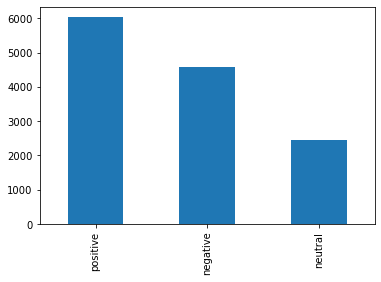

In [6]:
dyna_r2_train.gold_label.value_counts().plot.bar()

<AxesSubplot:>

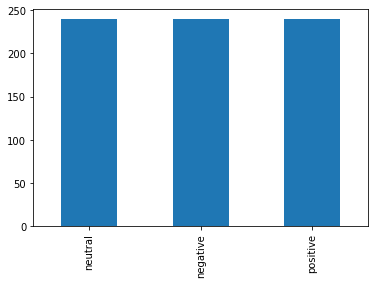

In [7]:
dyna_r2_dev.gold_label.value_counts().plot.bar()

## RNNClassifier wrapper

This section illustrates how to use `sst.experiment` with `TorchRNNClassifier`.

To featurize examples for an RNN, we can just get the words in order, letting the model take care of mapping them into an embedding space.

In [8]:
def rnn_phi(text):
    return text.split()

The model wrapper gets the vocabulary using `sst.get_vocab`. If you want to use pretrained word representations in here, then you can have `fit_rnn_classifier` build that space too; see [this notebook section for details](sst_03_neural_networks.ipynb#Pretrained-embeddings). See also [torch_model_base.py](torch_model_base.py) for details on the many optimization parameters that `TorchRNNClassifier` accepts.

In [9]:
# def fit_rnn_classifier(X, y):
#     sst_glove_vocab = utils.get_vocab(X, mincount=2)
#     mod = TorchRNNClassifier(
#         sst_glove_vocab,
#         early_stopping=True)
#     mod.fit(X, y)
#     return mod

In [10]:
# rnn_experiment = sst.experiment(
#     dyna_r2_train,
#     rnn_phi,
#     fit_rnn_classifier,
#     vectorize=False,
#     assess_dataframes=DEV_DATAFRAMES)


### Train and Save the Models

In [11]:
from sentiment_models import SentimentClassifierLSTM, SentimentClassifierRoberta, SentimentClassifierDynasent

transformer_hyperparams = {
    'gradient_accumulation_steps': 2,
    'eta': 2e-05,
    'max_iter': 20,
    'batch_size': 16,
    'n_iter_no_change': 5,
    'tol': 1e-7,
    'early_stopping': True,
    'display_progress': True,
}
search_hyperparams = {
    'gradient_accumulation_steps': [2],
    'eta': [2e-05],
    'max_iter': [20],
    'batch_size': [16],
    'n_iter_no_change': [5],
    'tol': [1e-7],
    'early_stopping': [True],
    'display_progress': [True],
}
lstm_hyperparams = {
    'tol': 1e-5,           # for "earlier stopping" to prevent overfitting
    'early_stopping': True,
}

def phi(text):
    return text

model_classes_to_test = [
    # (SentimentClassifierLSTM, lstm_hyperparams), # TODO(gabe) uncomment when implemented
    (SentimentClassifierRoberta, transformer_hyperparams),
    (SentimentClassifierDynasent, transformer_hyperparams),
]

for model_class, hyperparams in model_classes_to_test:
    for use_aan in [False, True]:
        print('Instantiating model...', ' ' * 1000, end='\r')
        model = model_class(use_aan, hyperparams)
        print(f'Beginning experiment on model {model}...', ' ' * 1000, end='\r')
        
        def train_classifier(X, y):
            basemod = model
            # utils.fit_classifier_with_hyperparameter_search(X, y, basemod, 5, search_hyperparams)
            basemod.fit(X, y)
            return basemod

        experiment = sst.experiment(
            TRAIN_DATAFRAMES,
            phi,
            train_classifier,
            assess_dataframes=DEV_DATAFRAMES,
            vectorize=False,
            verbose=True,
            random_state=42)

        torch.save(experiment, os.path.join('models', f'experiment_{model}.pt'))

        del experiment # Free memory, for continually test without GPU OOM

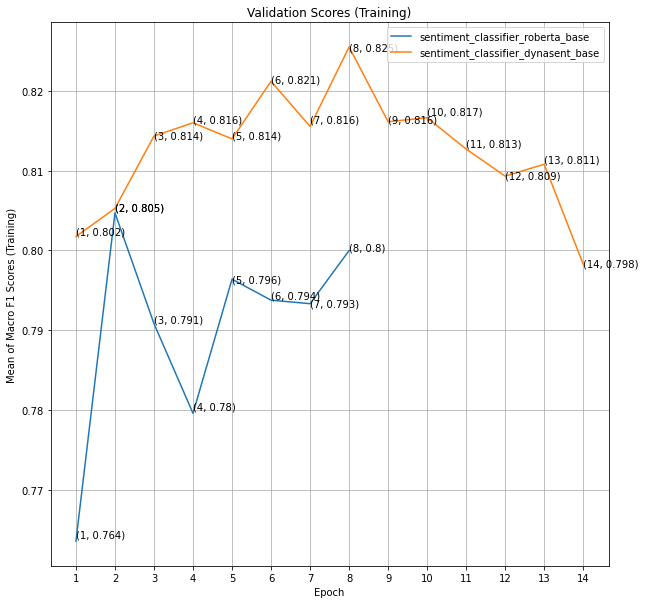

In [ ]:
# Plot validation scores computed during training on held-out portions of the train set
def plot_scores():
    from matplotlib import pyplot as plt
    # TODO graph .validation_scores
    plt.rcParams["figure.figsize"] = 10, 10
    for experiment in experiments:
        scores = experiment['model'].validation_scores
        epochs = list(range(1, len(scores) + 1))
        plt.plot(epochs, scores, label=f'{experiment["model"]}')
        # Data labels
        rounded_scores = [round(score, 3) for score in scores]
        for xy in zip(epochs, rounded_scores):
            plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.ylabel('Mean of Macro F1 Scores (Training)')
    plt.xlabel('Epoch')
    plt.title('Validation Scores (Training)')
    plt.grid()
    plt.xticks(epochs)
    plt.legend()


    plt.show()

plot_scores()